In [12]:
from mnist import MNIST
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
# import libraries

*IMPORTANT: PLEASE READ THE REPORT BEFORE GOING OVER THE CODE*

In [3]:
mndata = MNIST('C:/Users/glori/AMATH 563/HW1/')
mndata.gz=True
image_train, label_train = mndata.load_training()
image_test, label_test = mndata.load_testing()
train_x=np.array(image_train)
train_y=np.array(label_train)
test_x=np.array(image_test)
test_y=np.array(label_test)
train_y=to_categorical(train_y,10)
test_y=to_categorical(test_y,10)
#load data and convert labels to one-hot-coding

**Mapping Determination**

Use Least-squares, Ridge and Lasso to solve x and perform Grid Search to determine the hyperparameter alphas for Ridge and Lasso

In [5]:
lr=LinearRegression(normalize=True)
lr.fit(train_x,train_y)
x1=np.transpose(lr.coef_) #fit the data to linear regression model which performs least squares method

In [6]:
pred_test_lsf=np.mat(test_x)*np.mat(x1) #calculate prediction matrix for test set 
pred_label_lsf=(pred_test_lsf == pred_test_lsf.max(axis=1)).astype(int)  #pick the label with the max value of each row as the prediction
print('The accuracy score of least square fit is',accuracy_score(pred_label_lsf, test_y)) #use testing data to find accuracy

The accuracy score of least square fit is 0.8117


In [13]:
alphas=[0.01,0.02,0.1,0.5,1,2,5,10,25]
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True,cv=10)
ridgecv.fit(train_x, train_y)
print('The optimal alpha for ridge regression is',ridgecv.alpha_)
#search for the optimal alpha of ridge regression with 10-fold cross validation 

The optimal alpha for ridge regression is 1.0


In [14]:
rr_best=Ridge(alpha=1)
x2=rr_best.fit(train_x,train_y).coef_
x2=np.transpose(x2)
#fit the ridge regression model with alpha=1 and get coefficients

In [15]:
pred_test_r=np.mat(test_x)*np.mat(x2)
pred_label_r=(pred_test_r == pred_test_r.max(axis=1)).astype(int)
print('The accuracy score of ridge regression is',accuracy_score(pred_label_r, test_y)) #use testing data to find accuracy

The accuracy score of ridge regression is 0.8115


In [ ]:
ls = Lasso()
grid = GridSearchCV(estimator=ls, param_grid=dict(alpha=alphas))
grid.fit(train_x, train_y)
#search for the optimal alpha of lasso regression with leave-one-out cross validation 

In [19]:
print('The optimal alpha for lasso regression is',grid.best_estimator_.alpha)

The optimal alpha for lasso regression is 0.01


In [7]:
ls_best=Lasso(alpha=0.01)
x3=ls_best.fit(train_x,train_y).coef_ 
x3=np.transpose(x3)
#fit the lasso regression model with alpha=0.01 and get coefficients

In [8]:
pred_test_l=np.mat(test_x)*np.mat(x3)
pred_label_l=(pred_test_l == pred_test_l.max(axis=1)).astype(int)
print('The accuracy score of lasso regression is',accuracy_score(pred_label_l, test_y)) #use testing data to find accuracy

The accuracy score of lasso regression is 0.8126


Mappings of Each Model

<Figure size 3600x2160 with 0 Axes>

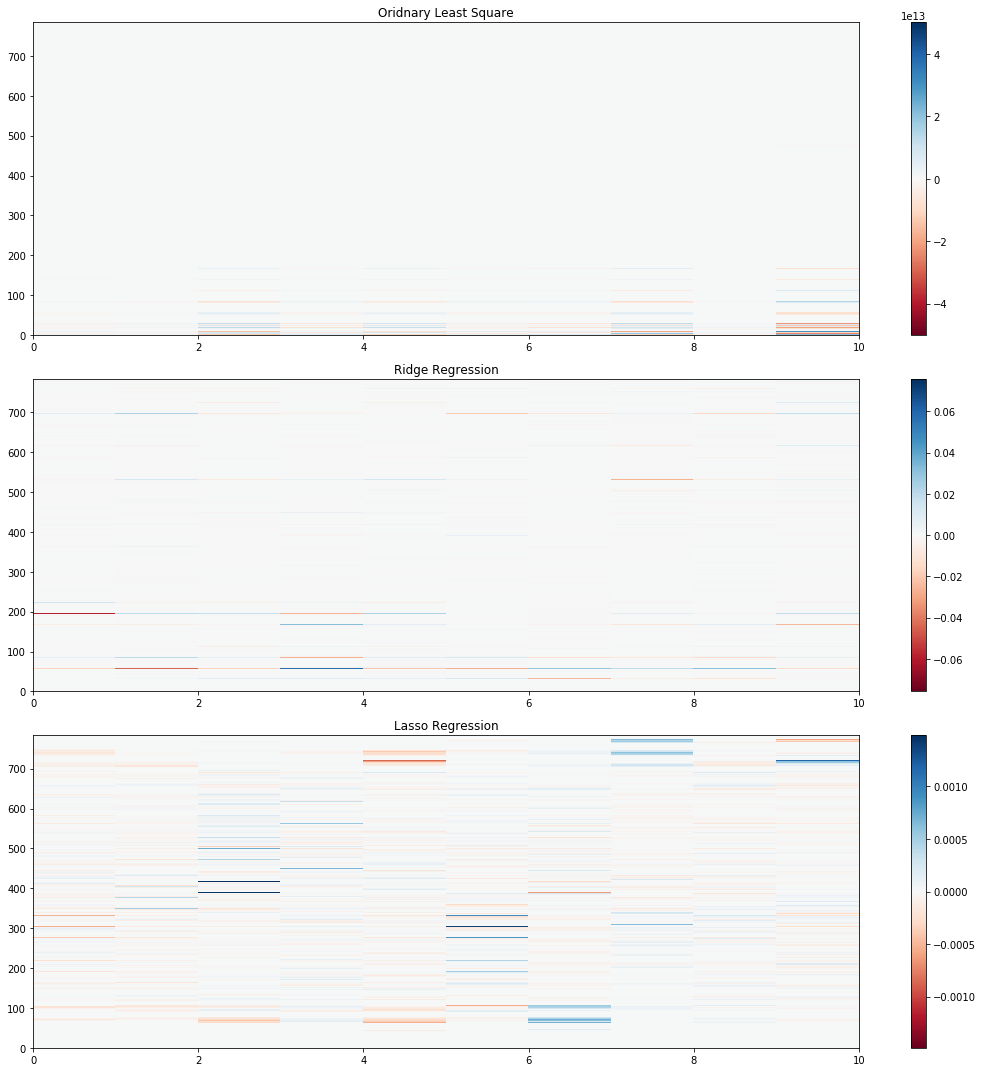

In [19]:
x1_min, x1_max = -np.abs(x1).max(), np.abs(x1).max()
x2_min, x2_max = -np.abs(x2).max(), np.abs(x2).max()
x3_min, x3_max = -np.abs(x3).max(), np.abs(x3).max()
plt.figure(figsize=(50, 30))
fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
fig.set_size_inches(15,15)
c = ax0.pcolor(x1, cmap='RdBu', vmin=x1_min, vmax=x1_max)
ax0.set_title('Oridnary Least Square')
fig.colorbar(c, ax=ax0)
c = ax1.pcolormesh(x2, cmap='RdBu', vmin=x2_min, vmax=x2_max)
ax1.set_title('Ridge Regression')
fig.colorbar(c, ax=ax1)
c = ax2.pcolormesh(x3, cmap='RdBu', vmin=x3_min, vmax=x3_max)
ax2.set_title('Lasso Regression')
fig.colorbar(c, ax=ax2)

fig.tight_layout()
plt.savefig('imshow of all three.jpg')

Lasso Mapping by Digit

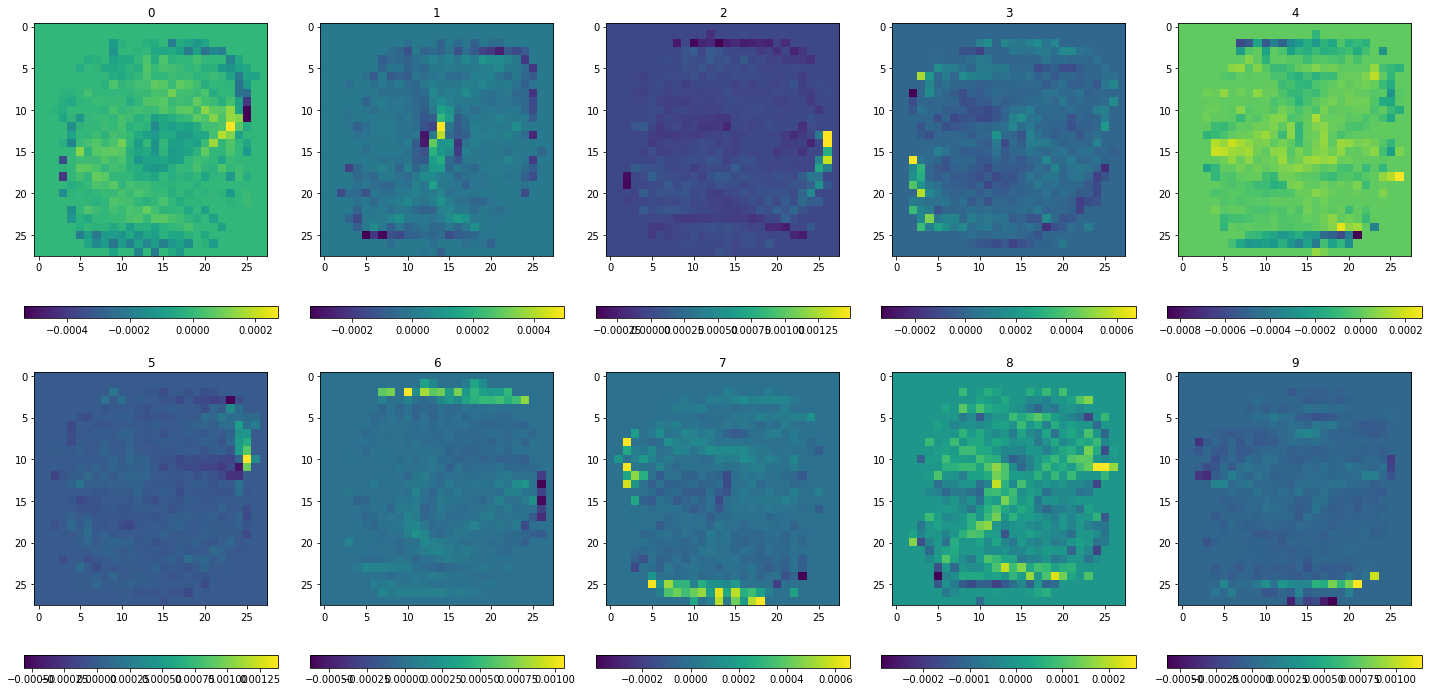

In [20]:
fig = plt.figure(figsize=(20, 10))

for i in range(1,11):
    im2=x3[:,i-1]
    im2=np.reshape(im2,(28,28))
    fig.add_subplot(2,5,i)
    ax=plt.imshow(im2)
    plt.title(i-1)
    fig.colorbar(ax,orientation='horizontal')

plt.tight_layout()
plt.savefig('lasso9.jpg')

Lasso Coefficient Distribution

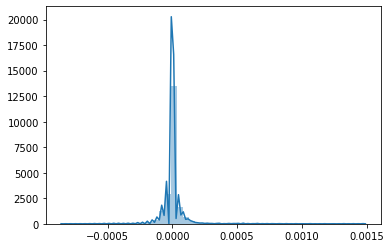

In [22]:
sns.distplot(x3)
plt.savefig('dist.jpg')

**Pixels Selection of Multiple Digit Prediction**

To promote pasity, lasso coefficients go through a loop and the ones in ranges [mean-i*sd,mean+i*sd] where i=[0.1,0.2,0.5,1,2,3,4] shrink to zero.

In [28]:
mean=np.mean(x3) #calcualte the mean of lasso loading
sig=np.std(x3) #calculate the standard deviation of lasso loading
row=len(x3) #the number of rows 
col=len(x3[0]) #the number of columns
siz=row*col #get size
count=[]
accuracy=[]
for i in [0.1,0.2,0.5,1,2,3,4]:
    xmin=mean-i*sig
    xmax=mean+i*sig
    x3_shrink=x3.copy()
    x3_shrink[(xmin<x3_shrink)&(x3_shrink<xmax)]=0 #shrink the coefficients within the range to zero
    K=np.count_nonzero(x3_shrink)
    count.append(siz-K) #the numbero f nonzero values in the updated loading
    pred_test=np.mat(test_x)*np.mat(x3_shrink)
    pred_label=(pred_test == pred_test.max(axis=1)).astype(int) 
    accu=accuracy_score(pred_label, test_y)
    accuracy.append(accu) #get prediction accuracy
    print("After promoting sparsity by setting the lasso coefficient values between mean -+",i, "*standard diviationn 0s, number of nonzero values in the updated loading is",K,",the accuracy is",accu,'\n')

After promoting sparsity by setting the lasso coefficient values between mean -+ 0.1 *standard diviationn 0s, number of nonzero values in the updated loading is 3617 ,the accuracy is 0.8124 

After promoting sparsity by setting the lasso coefficient values between mean -+ 0.2 *standard diviationn 0s, number of nonzero values in the updated loading is 3085 ,the accuracy is 0.8115 

After promoting sparsity by setting the lasso coefficient values between mean -+ 0.5 *standard diviationn 0s, number of nonzero values in the updated loading is 1888 ,the accuracy is 0.7723 

After promoting sparsity by setting the lasso coefficient values between mean -+ 1 *standard diviationn 0s, number of nonzero values in the updated loading is 807 ,the accuracy is 0.5921 

After promoting sparsity by setting the lasso coefficient values between mean -+ 2 *standard diviationn 0s, number of nonzero values in the updated loading is 266 ,the accuracy is 0.4208 

After promoting sparsity by setting the lasso 

In [25]:
pred_test=np.mat(test_x)*np.mat(x3)
pred_label=(pred_test == pred_test.max(axis=1)).astype(int)
accu1=accuracy_score(pred_label, test_y)
count.insert(0,siz-np.count_nonzero(x3))
accuracy.insert(0,accu1) #get accuracy and the nuumber of nonzero coefficients before sparsity promotion 

The Relationship between Sparsity and Model Performace of Multi-digit Prediction

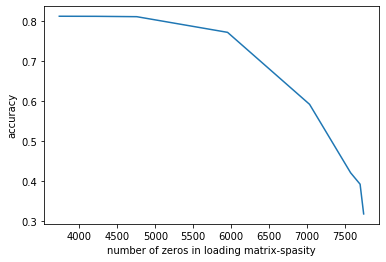

In [27]:
ax = sns.lineplot(x=count,y=accuracy)
ax.set_xlabel('number of zeros in loading matrix-spasity')
ax.set_ylabel('accuracy')
plt.savefig('multi-accu.jpg')

**Pixels Selection of Single Digit Prediction**

In this section, we bulild individual lasso model of each digit and promote sparsity respectively.

In [360]:
d_train_Y={}
d_test_Y={}
d_coef={}
alphas=[0.01,0.02,0.1,0.5,1,2,5,10,25]
for i in range(0,10):
        d_train_Y["y_train{0}".format(i)]=np.zeros(len(train_x))
        d_train_Y["y_train{0}".format(i)][np.where(train_y[:,i]==1)]=1
        d_test_Y["y_test{0}".format(i)]=np.zeros(len(test_x))
        d_test_Y["y_test{0}".format(i)][np.where(test_y[:,i]==1)]=1 #transform label matrices to a binary label vector with 1 when the image is digit i, 0 othewise
        ls = Lasso()
        grid = GridSearchCV(estimator=ls, param_grid=dict(alpha=alphas))
        grid.fit(train_x, d_train_Y["y_train{0}".format(i)])
        ls_best=Lasso(alpha=grid.best_estimator_.alpha) #get optimal lasso alpha for digit i
        x4=ls_best.fit(train_x,d_train_Y["y_train{0}".format(i)]).coef_ 
        d_coef["coeff{0}".format(i)]=np.transpose(x4) # get loading matrix for digit i

The Relationship between Sparsity and Model Performace of Single-digit Prediction

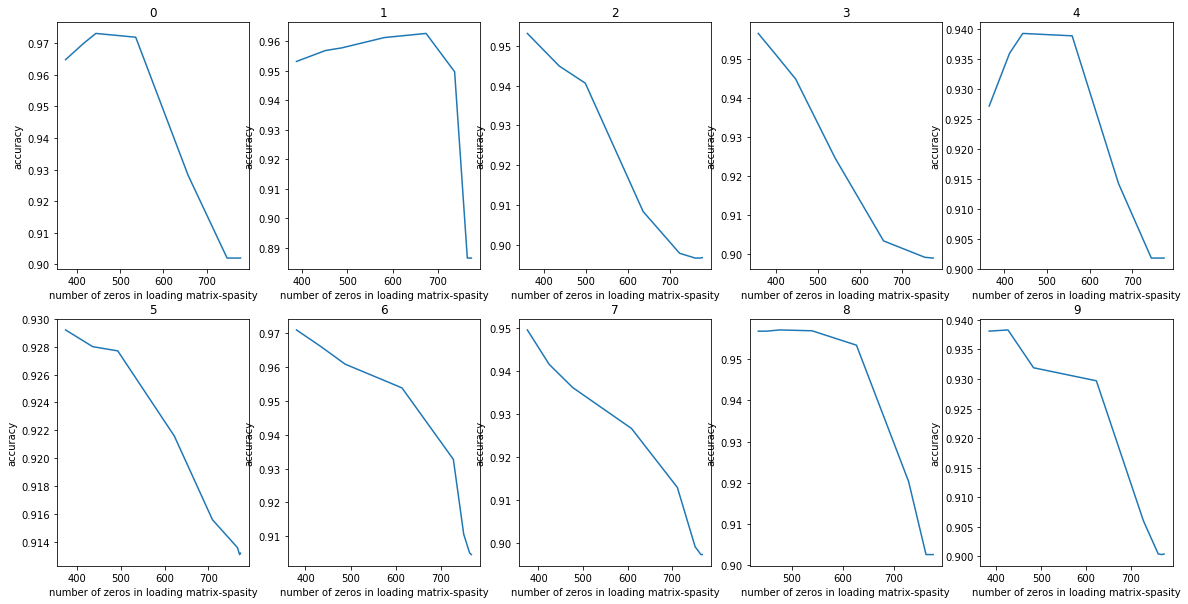

In [386]:
fig2 = plt.figure(figsize=(20, 10))
for j in range(0,10):
    x=np.transpose(d_coef["coeff{0}".format(j)])
    mean=np.mean(x) #calculate mean and standard deviation of the loading matrix for each digit
    sig=np.std(x)
    row=len(x)
    siz=row
    count=[]
    accuracy=[]
    for i in [0.1,0.2,0.5,1,2,3,4]: #get accuracy for each emperical rule of dimensionality reduction
        xmin=mean-i*sig
        xmax=mean+i*sig
        x_shrink=x.copy()
        x_shrink[(xmin<x_shrink)&(x_shrink<xmax)]=0
        K=np.count_nonzero(x_shrink)
        count.append(siz-K)
        pred_test=np.mat(test_x)*np.mat(x_shrink).T
        pred_label=(pred_test> 0.5).astype(int)
        accu=accuracy_score(pred_label, d_test_Y["y_test{0}".format(j)])
        accuracy.append(accu) 
    pred_test2=np.mat(test_x)*np.mat(x).T
    pred_label2=(pred_test2 >0.5).astype(int)
    accu2=accuracy_score(pred_label2, d_test_Y["y_test{0}".format(j)])
    count.insert(0,siz-np.count_nonzero(x))
    accuracy.insert(0,accu2) 
    fig2.add_subplot(2,5,j+1)
    ax = sns.lineplot(x=count,y=accuracy)
    ax.set_xlabel('number of zeros in loading matrix-spasity')
    ax.set_ylabel('accuracy')
    ax.set_title(j)

**Thank you for reading!**